## Credit Card Approval Prediction

### Introduction
In this notebook we see how to use logistic regression to predict credit card approvals. The dataset contains various attributes related to credit card applicants and whether their application was approved. The goal is to create a predictive model to determine the likelihood of approval based on these attributes.

### Dataset
The dataset consists of several features, including both numerical and categorical data. Missing values and categorical data are handled appropriately to ensure the model's accuracy and robustness. You can find the dataset in https://archive.ics.uci.edu/dataset/27/credit+approval

### Code Walkthrough
The following sections will provide a detailed walkthrough of the code, including data preprocessing, model training, evaluation, and visualization.


---
### Importing Libraries
We start by importing the necessary libraries.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the Data
Now we load the dataset and take a look at the data.

In [2]:
# pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
credit_approval = fetch_ucirepo(id=27) 
  
# data (as pandas dataframes) 
X = credit_approval.data.features 
y = credit_approval.data.targets 
  
# metadata 
print(credit_approval.metadata) 
  
# variable information 
print(credit_approval.variables) 

{'uci_id': 27, 'name': 'Credit Approval', 'repository_url': 'https://archive.ics.uci.edu/dataset/27/credit+approval', 'data_url': 'https://archive.ics.uci.edu/static/public/27/data.csv', 'abstract': 'This data concerns credit card applications; good mix of attributes', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 690, 'num_features': 15, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['A16'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1987, 'last_updated': 'Wed Aug 23 2023', 'dataset_doi': '10.24432/C5FS30', 'creators': ['J. R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This file concerns credit card applications.  All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data.\r\n  \r\nThis dataset is interesting because there is a good mix of attributes --

In [3]:
print("------------------------------- Features ---------------------------")
print(X.head())
print("\n")
print(X.tail(20))
print("\n")
print(X.shape)
print("\n")
print(X.info())
print("\n")
print("\n")
print("------------------------------- Target ---------------------------")
print(y.head())
print("\n")
print(y.tail(20))
print("\n")
print(y.shape)
print("\n")
print(y.info())

------------------------------- Features ---------------------------
   A15    A14 A13 A12  A11 A10 A9    A8 A7 A6 A5 A4     A3     A2 A1
0    0  202.0   g   f    1   t  t  1.25  v  w  g  u  0.000  30.83  b
1  560   43.0   g   f    6   t  t  3.04  h  q  g  u  4.460  58.67  a
2  824  280.0   g   f    0   f  t  1.50  h  q  g  u  0.500  24.50  a
3    3  100.0   g   t    5   t  t  3.75  v  w  g  u  1.540  27.83  b
4    0  120.0   s   f    0   f  t  1.71  v  w  g  u  5.625  20.17  b


     A15    A14 A13 A12  A11 A10 A9     A8  A7  A6 A5 A4      A3     A2   A1
670  150  465.0   g   f    0   f  f  5.500   v   w  g  u   5.835  47.17    b
671    2    0.0   g   f    0   f  f  0.500   v  cc  g  u  12.835  25.83    b
672  117  240.0   g   t    0   f  f  0.500   v  aa  g  u   0.835  50.25    a
673   17  256.0   g   f    0   f  f  2.000   h   e  p  y   2.000  29.50  NaN
674  246  260.0   g   f    0   f  f  0.210   h   i  g  u   2.500  37.33    a
675  237  240.0   g   f    0   f  f  0.665   v  aa  g

### Handling Missing Values and Encoding Categorical Data

We handle the missing values by filling them with next value using forward fill.

In [4]:
# Fill NA values with forward fill
X = X.ffill()

print(X.count())
X.tail(20)

# Verify there are no missing values
print(X.isnull().values.any())
print(X.isna().values.any())
print(X.isnull().sum())

A15    690
A14    690
A13    690
A12    690
A11    690
A10    690
A9     690
A8     690
A7     690
A6     690
A5     690
A4     690
A3     690
A2     690
A1     690
dtype: int64
False
False
A15    0
A14    0
A13    0
A12    0
A11    0
A10    0
A9     0
A8     0
A7     0
A6     0
A5     0
A4     0
A3     0
A2     0
A1     0
dtype: int64


### Encoding Categorical Data
Encode categorical features using LabelEncoder. We need to transform features to numbers for using logistic regression


In [5]:
# Checking data types
X.dtypes

A15      int64
A14    float64
A13     object
A12     object
A11      int64
A10     object
A9      object
A8     float64
A7      object
A6      object
A5      object
A4      object
A3     float64
A2     float64
A1      object
dtype: object

In [6]:
# We can use label encoder for object types
encoder = LabelEncoder()

In [7]:
for var in X.columns:
    if X[var].dtype == 'object':
        X[var] = encoder.fit_transform(X[var])
        
print(X.head())
print(X.dtypes)

   A15    A14  A13  A12  A11  A10  A9    A8  A7  A6  A5  A4     A3     A2  A1
0    0  202.0    0    0    1    1   1  1.25   7  12   0   1  0.000  30.83   1
1  560   43.0    0    0    6    1   1  3.04   3  10   0   1  4.460  58.67   0
2  824  280.0    0    0    0    0   1  1.50   3  10   0   1  0.500  24.50   0
3    3  100.0    0    1    5    1   1  3.75   7  12   0   1  1.540  27.83   1
4    0  120.0    2    0    0    0   1  1.71   7  12   0   1  5.625  20.17   1
A15      int64
A14    float64
A13      int64
A12      int64
A11      int64
A10      int64
A9       int64
A8     float64
A7       int64
A6       int64
A5       int64
A4       int64
A3     float64
A2     float64
A1       int64
dtype: object


array([[<Axes: title={'center': 'A15'}>, <Axes: title={'center': 'A14'}>,
        <Axes: title={'center': 'A13'}>, <Axes: title={'center': 'A12'}>],
       [<Axes: title={'center': 'A11'}>, <Axes: title={'center': 'A10'}>,
        <Axes: title={'center': 'A9'}>, <Axes: title={'center': 'A8'}>],
       [<Axes: title={'center': 'A7'}>, <Axes: title={'center': 'A6'}>,
        <Axes: title={'center': 'A5'}>, <Axes: title={'center': 'A4'}>],
       [<Axes: title={'center': 'A3'}>, <Axes: title={'center': 'A2'}>,
        <Axes: title={'center': 'A1'}>, <Axes: >]], dtype=object)

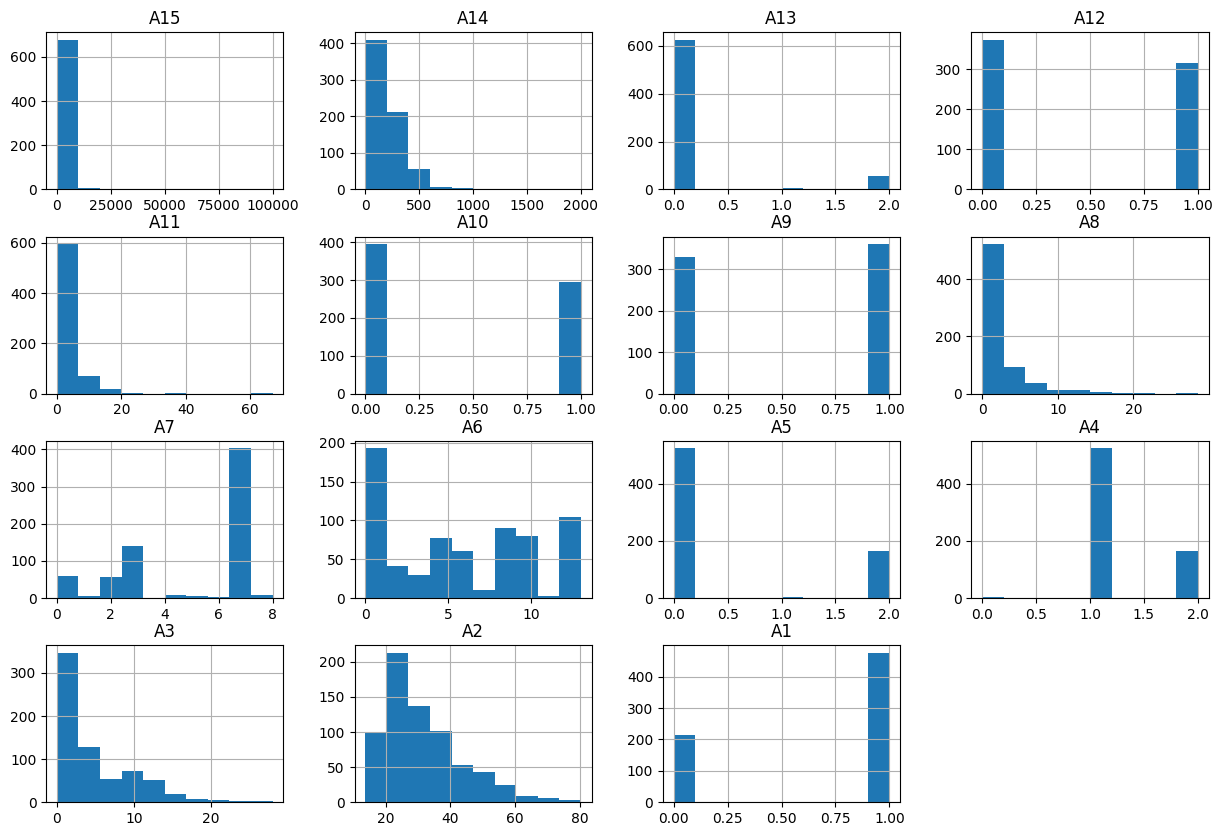

In [8]:
# looking the histograms
X.hist(figsize=(15,10))

As we can see, some columns need to be processed to train the logistic regression model effectively. To do this, we can classify the values of each one of the continous variables. Let's take a look at each one of them, A2, A3, A8, A11, A14 and A15

In [9]:
X['A2'].describe()

count    690.000000
mean      31.483058
std       11.912872
min       13.750000
25%       22.580000
50%       28.375000
75%       37.750000
max       80.250000
Name: A2, dtype: float64

The min value is 13.75 and max 80.25, it can be classified between its minimum and maximum value in increments of 4 units.

In [10]:
# Create intervals of 4 units
A2_int = list(range(int(X.A2.min()), int(X.A2.max()), 4))

# Name the invervals
name_int = [f'A2_i{i}' for i in range(len(A2_int)-1)]

# Add the intervals to the DataFrame as a new column
X['A2_int'] = pd.cut(X.A2, A2_int, labels = name_int, include_lowest = True)

In [11]:
# Analyzing A2 as cross table with target

cross_X = pd.crosstab(index = y["A16"], columns = X["A2_int"])
cross_X.index = ["Rejected", "Accepted"]

cross_X

A2_int,A2_i0,A2_i1,A2_i2,A2_i3,A2_i4,A2_i5,A2_i6,A2_i7,A2_i8,A2_i9,A2_i10,A2_i11,A2_i12,A2_i13,A2_i14,A2_i15
Rejected,4,42,56,44,25,30,26,22,20,8,10,11,2,4,1,2
Accepted,16,63,84,51,48,43,29,15,9,11,4,3,3,0,2,1


Repeating the same process for the other variables

In [12]:
print(X['A3'].describe())
print(X['A8'].describe())
print(X['A11'].describe())
print(X['A14'].describe())
print(X['A15'].describe())

count    690.000000
mean       4.758725
std        4.978163
min        0.000000
25%        1.000000
50%        2.750000
75%        7.207500
max       28.000000
Name: A3, dtype: float64
count    690.000000
mean       2.223406
std        3.346513
min        0.000000
25%        0.165000
50%        1.000000
75%        2.625000
max       28.500000
Name: A8, dtype: float64
count    690.00000
mean       2.40000
std        4.86294
min        0.00000
25%        0.00000
50%        0.00000
75%        3.00000
max       67.00000
Name: A11, dtype: float64
count     690.000000
mean      183.792754
std       173.567750
min         0.000000
25%        73.000000
50%       160.000000
75%       280.000000
max      2000.000000
Name: A14, dtype: float64
count       690.000000
mean       1017.385507
std        5210.102598
min           0.000000
25%           0.000000
50%           5.000000
75%         395.500000
max      100000.000000
Name: A15, dtype: float64


In [13]:
# Using the same increment of 4 steps
A3_int = list(range(int(X.A3.min()), int(X.A3.max()), 4))
A8_int = list(range(int(X.A8.min()), int(X.A8.max()), 4))
A11_int = list(range(int(X.A11.min()), int(X.A11.max()), 4))
A14_int = list(range(int(X.A14.min()), int(X.A14.max()), 4))
A15_int = list(range(int(X.A15.min()), int(X.A15.max()), 4))

# Naming intervals
name_int_A3 = [f'A3_i{i}' for i in range(len(A3_int)-1)]
name_int_A8 = [f'A8_i{i}' for i in range(len(A8_int)-1)]
name_int_A11 = [f'A11_i{i}' for i in range(len(A11_int)-1)]
name_int_A14 = [f'A14_i{i}' for i in range(len(A14_int)-1)]
name_int_A15 = [f'A15_i{i}' for i in range(len(A15_int)-1)]

# Adding to dataframe X
X['A3_int'] = pd.cut(X.A3, A3_int, labels = name_int_A3, include_lowest = True)
X['A8_int'] = pd.cut(X.A8, A8_int, labels = name_int_A8, include_lowest = True)
X['A11_int'] = pd.cut(X.A11, A11_int, labels = name_int_A11, include_lowest = True)
X['A14_int'] = pd.cut(X.A14, A14_int, labels = name_int_A14, include_lowest = True)
X['A15_int'] = pd.cut(X.A15, A15_int, labels = name_int_A15, include_lowest = True)

print(X)

     A15    A14  A13  A12  A11  A10  A9    A8  A7  A6  ...  A4      A3     A2  \
0      0  202.0    0    0    1    1   1  1.25   7  12  ...   1   0.000  30.83   
1    560   43.0    0    0    6    1   1  3.04   3  10  ...   1   4.460  58.67   
2    824  280.0    0    0    0    0   1  1.50   3  10  ...   1   0.500  24.50   
3      3  100.0    0    1    5    1   1  3.75   7  12  ...   1   1.540  27.83   
4      0  120.0    2    0    0    0   1  1.71   7  12  ...   1   5.625  20.17   
..   ...    ...  ...  ...  ...  ...  ..   ...  ..  ..  ...  ..     ...    ...   
685    0  260.0    0    0    0    0   0  1.25   3   4  ...   2  10.085  21.08   
686  394  200.0    0    1    2    1   0  2.00   7   1  ...   1   0.750  22.67   
687    1  200.0    0    1    1    1   0  2.00   2   5  ...   2  13.500  25.25   
688  750  280.0    0    0    0    0   0  0.04   7   0  ...   1   0.205  17.92   
689    0    0.0    0    1    0    0   0  8.29   3   1  ...   1   3.375  35.00   

     A1  A2_int A3_int A8_i

In [14]:
# Removing the variables we dont need anymore
X = X.drop(["A2", "A3", "A8", "A11", "A14", "A15"], axis=1)
X.head()

,A13,A12,A10,A9,A7,A6,A5,A4,A1,A2_int,A3_int,A8_int,A11_int,A14_int,A15_int
0,0,0,1,1,7,12,0,1,1,A2_i4,A3_i0,A8_i0,A11_i0,A14_i50,A15_i0
1,0,0,1,1,3,10,0,1,0,A2_i11,A3_i1,A8_i0,A11_i1,A14_i10,A15_i139
2,0,0,0,1,3,10,0,1,0,A2_i2,A3_i0,A8_i0,A11_i0,A14_i69,A15_i205
3,0,1,1,1,7,12,0,1,1,A2_i3,A3_i0,A8_i0,A11_i1,A14_i24,A15_i0
4,2,0,0,1,7,12,0,1,1,A2_i1,A3_i1,A8_i0,A11_i0,A14_i29,A15_i0


In [15]:
# Renaming the columns
X.columns = X.columns.str.replace('_int', '')
X.head()

,A13,A12,A10,A9,A7,A6,A5,A4,A1,A2,A3,A8,A11,A14,A15
0,0,0,1,1,7,12,0,1,1,A2_i4,A3_i0,A8_i0,A11_i0,A14_i50,A15_i0
1,0,0,1,1,3,10,0,1,0,A2_i11,A3_i1,A8_i0,A11_i1,A14_i10,A15_i139
2,0,0,0,1,3,10,0,1,0,A2_i2,A3_i0,A8_i0,A11_i0,A14_i69,A15_i205
3,0,1,1,1,7,12,0,1,1,A2_i3,A3_i0,A8_i0,A11_i1,A14_i24,A15_i0
4,2,0,0,1,7,12,0,1,1,A2_i1,A3_i1,A8_i0,A11_i0,A14_i29,A15_i0


In [16]:
# Now we can use label encoder again for categorical types in X
for var in X.columns:
    if X[var].dtype == 'category':
        X[var] = encoder.fit_transform(X[var])

# Converting the target 'A16' to binary numeric values (0 and 1) for modeling
y['A16'] = pd.to_numeric(np.where(y['A16'] == '-', 0, 1), downcast='integer')

print(X.head())
print(X.tail())

print(y.head())
print(y.tail())

   A13  A12  A10  A9  A7  A6  A5  A4  A1  A2  A3  A8  A11  A14  A15
0    0    0    1   1   7  12   0   1   1  10   0   0    0   74    0
1    0    0    1   1   3  10   0   1   0   3   1   0    1    1   27
2    0    0    0   1   3  10   0   1   0   8   0   0    0   91   61
3    0    1    1   1   7  12   0   1   1   9   0   0    1   46    0
4    2    0    0   1   7  12   0   1   1   1   1   0    0   52    0
     A13  A12  A10  A9  A7  A6  A5  A4  A1  A2  A3  A8  A11  A14  A15
685    0    0    0   0   3   4   2   2   1   8   2   0    0   86    0
686    0    1    1   0   7   1   0   1   0   8   0   0    0   72  190
687    0    1    1   0   2   5   2   2   0   9   3   0    0   72    0
688    0    0    0   0   7   0   0   1   1   1   0   0    0   91   51
689    0    1    0   0   3   1   0   1   1  11   0   2    0    0    0
   A16
0    1
1    1
2    1
3    1
4    1
     A16
685    0
686    0
687    0
688    0
689    0


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_11816\1486138817.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['A16'] = pd.to_numeric(np.where(y['A16'] == '-', 0, 1), downcast='integer')


### Splitting the Dataset
Split the dataset into training and testing sets.

In [17]:
# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

### Model Training
Train a logistic regression model using the training data.

In [18]:
# Initialize the instance and train the model
x_train_ = sm.add_constant(x_train)
x_test_ = sm.add_constant(x_test)

reg_log = sm.GLM(y_train, x_train_, family = sm.families.Binomial())

reg_log = reg_log.fit()

print(reg_log.summary())
print("\n")
print("Parameters: ", reg_log.params)
print("\n")
print("Odds ratio")
print(np.exp(reg_log.params))


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    A16   No. Observations:                  345
Model:                            GLM   Df Residuals:                      329
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -112.38
Date:                Tue, 29 Oct 2024   Deviance:                       224.76
Time:                        13:11:12   Pearson chi2:                     329.
No. Iterations:                    19   Pseudo R-squ. (CS):             0.5142
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8352   1.18e+04      0.001      0.9

### Model Evaluation
Evaluate the model using the testing data and generate a confusion matrix.

In [19]:
# Evaluating
y_pred_train = reg_log.predict(x_train_)

y_pred_test = reg_log.predict(x_test_)

# Calculating ROC and Gini - Train
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

print("AUC - Train: %f" %roc_auc_train)
print("Gini - Train: ", round(2*roc_auc_train-1, 2))
print("\n")

# Calculating ROC and Gini - Test
fpr_test, tpr_test, threshoulds_test = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

print("AUC - Test : %f" %roc_auc_test)
print("Gini - Test: ", round(2*roc_auc_test-1, 2))

AUC - Train: 0.930147
Gini - Train:  0.86


AUC - Test : 0.910451
Gini - Test:  0.82


In [20]:
# Best point happens when True Positive cross False Positive

i = np.arange(len(tpr_train))
roc_train = pd.DataFrame({'fpr': pd.Series(fpr_train, index = i)
                          , 'tpr': pd.Series(tpr_train, index = i)
                          , '1-fpr': pd.Series(1-fpr_train, index = i)
                          , 'tf': pd.Series(tpr_train - (1-fpr_train), index = i)
                          , 'thresholds': pd.Series(thresholds_train, index=i)})

print(round(roc_train.loc[(roc_train.tf-0).abs().argsort()[:1]],3))

     fpr    tpr  1-fpr     tf  thresholds
43  0.13  0.869   0.87 -0.001       0.602


### ROC Curve
Plot the ROC curve to evaluate the model's performance.

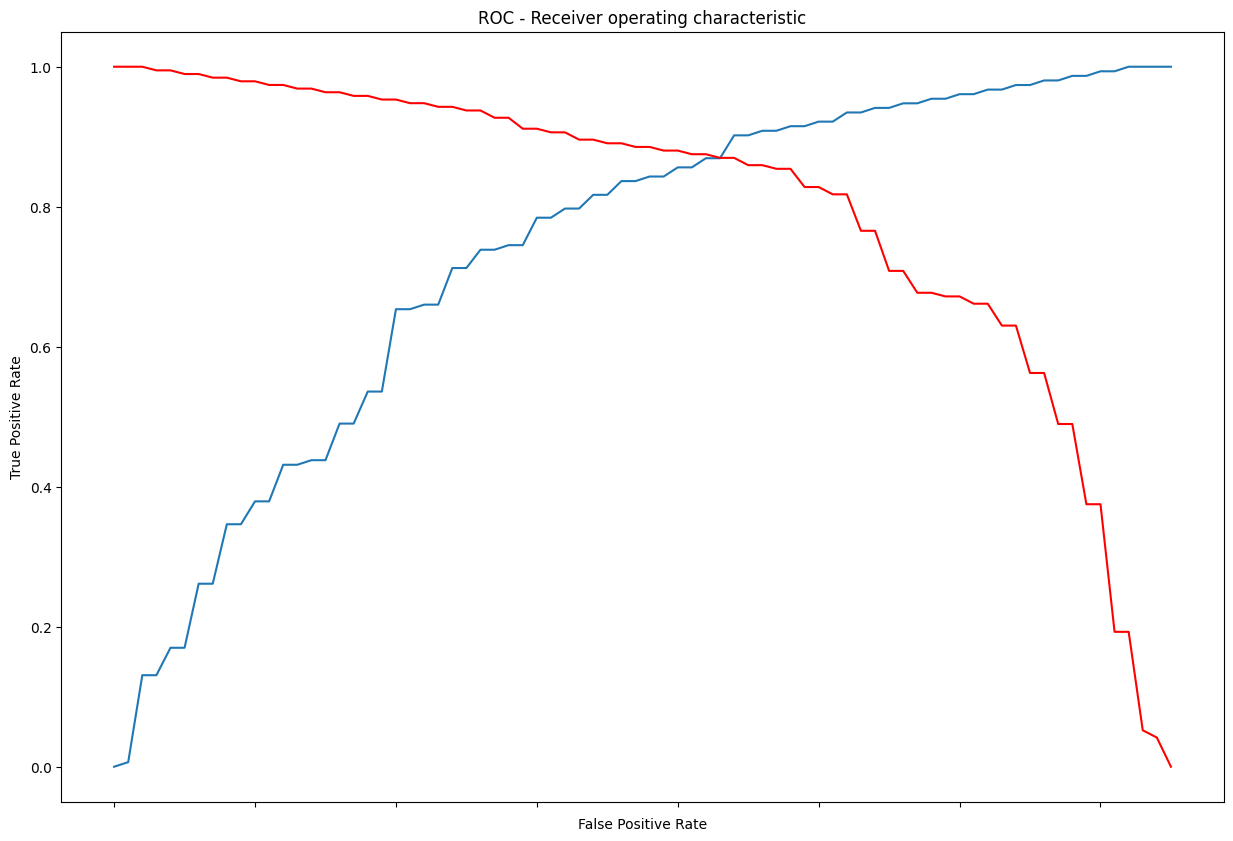

In [21]:
# Ploting ROC - Training

fig, ax = plt.subplots()
plt.plot(roc_train['tpr'])
plt.plot(roc_train['1-fpr'], color = 'red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
ax.set_xticklabels([]);
plt.gcf().set_size_inches(15, 10)

(array([144.,  15.,   1.,   3.,   3.,  14.,  19.,  42.,  50.,  54.]),
 array([0.00863523, 0.1077717 , 0.20690818, 0.30604466, 0.40518114,
        0.50431761, 0.60345409, 0.70259057, 0.80172704, 0.90086352,
        1.        ]),
 <BarContainer object of 10 artists>)

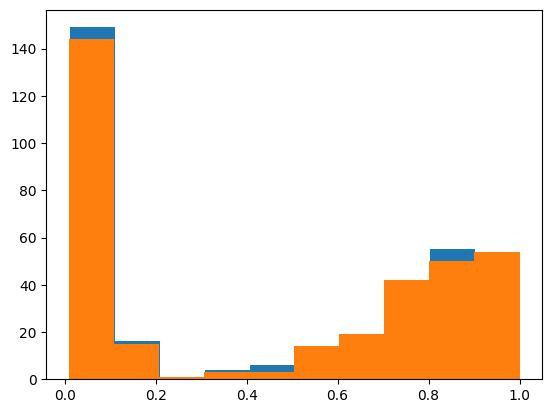

In [22]:
# Adjusting cutoff

cutoff = 0.602

plt.hist(y_pred_train)
plt.hist(y_pred_test)

In [23]:
# Pre processing for confusion matrix
from sklearn.metrics import confusion_matrix

y_pred_train_bin = y_pred_train
y_pred_test_bin = y_pred_test

for score in range(0, len(y_pred_train-1)):
    if y_pred_train.iloc[score] >= cutoff:
        y_pred_train_bin.iloc[score] = 1
    else:
        y_pred_train_bin.iloc[score] = 0

for score in range(0, len(y_pred_test-1)):
    if y_pred_test.iloc[score] >= cutoff:
        y_pred_test_bin.iloc[score] = 1
    else:
        y_pred_test_bin.iloc[score] = 0

In [24]:
# Evaluating the training base
print("Evaluating the training base:")
print(confusion_matrix(y_train, y_pred_train_bin))
print("\n")

#Evaluating the test base
print("Evaluating the test base:")
print(confusion_matrix(y_test, y_pred_test_bin))

Evaluating the training base:
[[168  24]
 [ 20 133]]


Evaluating the test base:
[[163  28]
 [ 17 137]]


Let's try to train the model again without A4 and A5 to check if makes any difference. The choice for removing A4 and A5 it's based on the coef and odds ratio values of these variables

In [25]:
# New dataframe X2 without A4 and A5
X2 = X.drop(["A4", "A5"], axis=1)
X2

,A13,A12,A10,A9,A7,A6,A1,A2,A3,A8,A11,A14,A15
0,0,0,1,1,7,12,1,10,0,0,0,74,0
1,0,0,1,1,3,10,0,3,1,0,1,1,27
2,0,0,0,1,3,10,0,8,0,0,0,91,61
3,0,1,1,1,7,12,1,9,0,0,1,46,0
4,2,0,0,1,7,12,1,1,1,0,0,52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0,0,0,0,3,4,1,8,2,0,0,86,0
686,0,1,1,0,7,1,0,8,0,0,0,72,190
687,0,1,1,0,2,5,0,9,3,0,0,72,0
688,0,0,0,0,7,0,1,1,0,0,0,91,51


In [26]:
# Spliting the new data
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.5, random_state = 42)

In [27]:
# Initialize the instance and train the new model
x2_train_ = sm.add_constant(x2_train)
x2_test_ = sm.add_constant(x2_test)

reg_log2 = sm.GLM(y2_train, x2_train_, family = sm.families.Binomial())

reg_log2 = reg_log2.fit()

print(reg_log2.summary())
print("\n")
print("Parameters: ", reg_log2.params)
print("\n")
print("Odds ratio")
print(np.exp(reg_log2.params))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    A16   No. Observations:                  345
Model:                            GLM   Df Residuals:                      331
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -116.85
Date:                Tue, 29 Oct 2024   Deviance:                       233.70
Time:                        13:11:13   Pearson chi2:                     357.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5015
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4358      0.767     -4.480      0.0

In [28]:
# Evaluating
y2_pred_train = reg_log2.predict(x2_train_)

y2_pred_test = reg_log2.predict(x2_test_)

# Calculating ROC and Gini - Train
fpr_train2, tpr_train2, thresholds_train2 = roc_curve(y2_train, y2_pred_train)
roc_auc_train2 = auc(fpr_train2, tpr_train2)

print("AUC - Train: %f" %roc_auc_train2)
print("Gini - Train: ", round(2*roc_auc_train2-1, 2))
print("\n")

# Calculating ROC and Gini - Test
fpr_test2, tpr_test2, threshoulds_test2 = roc_curve(y2_test, y2_pred_test)
roc_auc_test2 = auc(fpr_test2, tpr_test2)

print("AUC - Test : %f" %roc_auc_test2)
print("Gini - Test: ", round(2*roc_auc_test2-1, 2))

AUC - Train: 0.921909
Gini - Train:  0.84


AUC - Test : 0.899912
Gini - Test:  0.8


In [29]:
# Best point happens when True Positive cross False Positive

i = np.arange(len(tpr_train2))
roc_train2 = pd.DataFrame({'fpr': pd.Series(fpr_train2, index = i)
                          , 'tpr': pd.Series(tpr_train2, index = i)
                          , '1-fpr': pd.Series(1-fpr_train2, index = i)
                          , 'tf': pd.Series(tpr_train2 - (1-fpr_train2), index = i)
                          , 'thresholds': pd.Series(thresholds_train2, index=i)})

print(round(roc_train2.loc[(roc_train2.tf-0).abs().argsort()[:1]],3))

      fpr    tpr  1-fpr     tf  thresholds
40  0.125  0.876  0.875  0.001       0.597


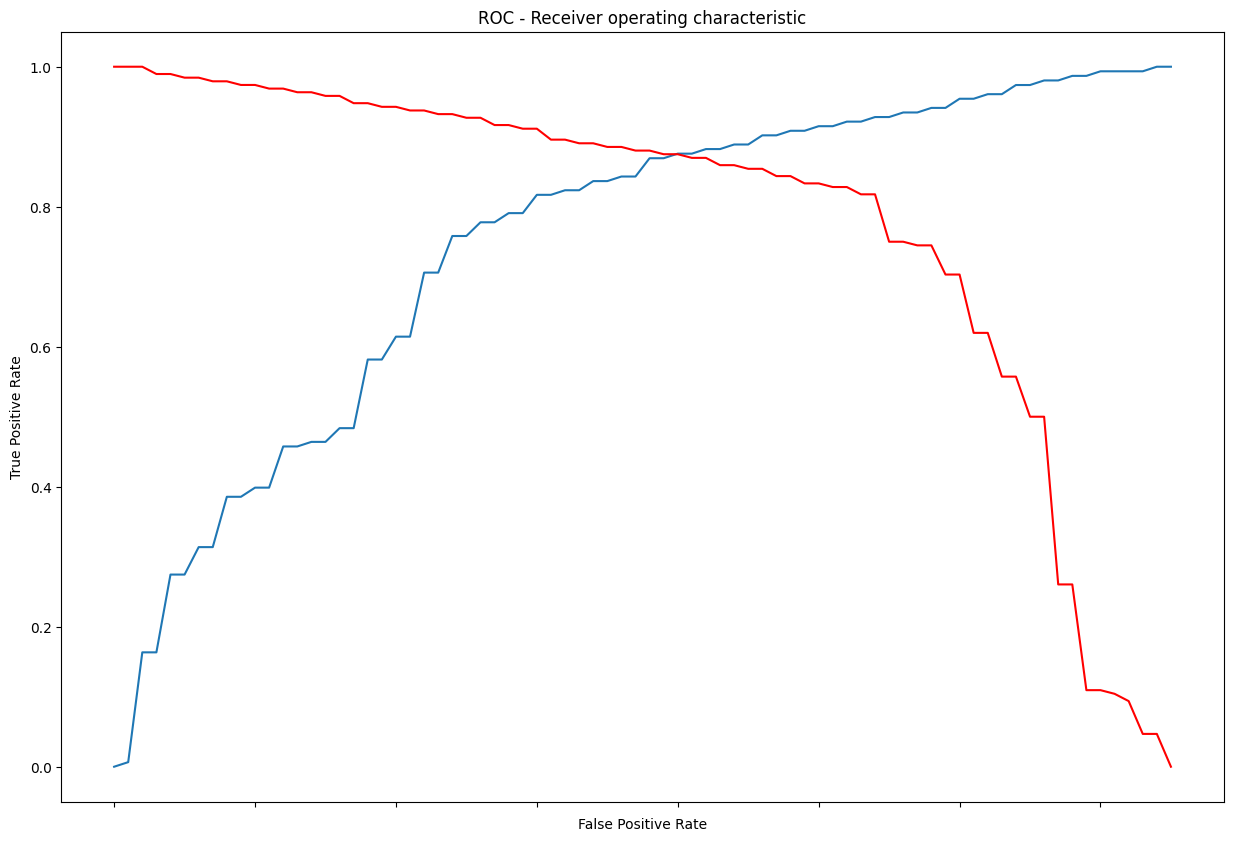

In [30]:
# Ploting ROC - Training

fig, ax = plt.subplots()
plt.plot(roc_train2['tpr'])
plt.plot(roc_train2['1-fpr'], color = 'red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
ax.set_xticklabels([]);
plt.gcf().set_size_inches(15, 10)

(array([145.,  16.,   0.,   0.,   5.,  10.,  28.,  37.,  56.,  48.]),
 array([0.02181487, 0.1193939 , 0.21697294, 0.31455197, 0.412131  ,
        0.50971003, 0.60728907, 0.7048681 , 0.80244713, 0.90002616,
        0.99760519]),
 <BarContainer object of 10 artists>)

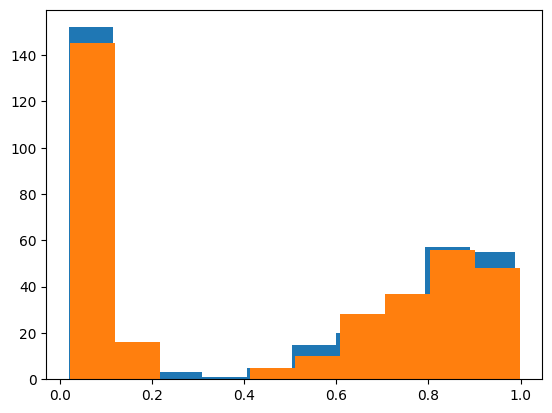

In [31]:
# Adjusting cutoff

cutoff = 0.596

plt.hist(y2_pred_train)
plt.hist(y2_pred_test)

In [32]:
# Pre processing for confusion matrix
from sklearn.metrics import confusion_matrix

y2_pred_train_bin = y2_pred_train
y2_pred_test_bin = y2_pred_test

for score in range(0, len(y2_pred_train-1)):
    if y2_pred_train.iloc[score] >= cutoff:
        y2_pred_train_bin.iloc[score] = 1
    else:
        y2_pred_train_bin.iloc[score] = 0

for score in range(0, len(y_pred_test-1)):
    if y2_pred_test.iloc[score] >= cutoff:
        y2_pred_test_bin.iloc[score] = 1
    else:
        y2_pred_test_bin.iloc[score] = 0

In [33]:
# Evaluating the training base
print("Evaluating the training base:")
print(confusion_matrix(y2_train, y2_pred_train_bin))
print("\n")

#Evaluating the test base
print("Evaluating the test base:")
print(confusion_matrix(y2_test, y2_pred_test_bin))

Evaluating the training base:
[[167  25]
 [ 19 134]]


Evaluating the test base:
[[158  33]
 [ 16 138]]
